Задача 7.3. Для линейной гауссовской системы наблюдения (скалярное состояние, ска-лярное наблюдение)

𝑋𝑡= 𝑎𝑡𝑋𝑡−1+ 𝑏𝑡𝑉𝑡,𝑡 ∈[0,𝑇], 𝑋0 ~ 𝒩(0,𝐷0), 𝑌𝑡= 𝐴𝑡𝑋𝑡+𝐵𝑡𝑊𝑡,

построить оценки фильтрации Калмана в прямом и обратном времени состояния 𝑋𝑡, а также оценку сглаживания на фиксированном интервале [0,𝑇].

1) Для параметров (𝐷0,𝑇,𝑎𝑡,𝑏𝑡,𝐴𝑡,𝐵𝑡)=(1,100,1,0.5,1,1) на одном рисунке построить истинное значение состояния, ее оценки фильтрации в прямом и обратном времени, а также оценку сглаживания.

2) Для параметров (𝐷0,𝑇,𝑎𝑡,𝑏𝑡,𝐴𝑡,𝐵𝑡)=(1,100,1,0.5,1,1) на одном рисунке построить СКО состояния 𝑋𝑡, СКО ошибки фильтрации в прямом времени, СКО ошибки фильтра-ции в обратном времени и СКО ошибки сглаживания.

3) Повторить пп. 1) и 2) для (𝐷0,𝑇,𝑎𝑡,𝑏𝑡,𝐴𝑡,𝐵𝑡)=(1,100,−0.5,0.5,1,1).

In [1]:
import numpy as np
import copy
import matplotlib.pylab as plt

In [2]:
def create_real(m0, d0, a_t, b_t, A_t, B_t, X_0, Y_0, t_end):
  X, Y = [X_0], [Y_0]
  W = np.random.normal(loc=m0, scale=d0, size = t_end)
  V = np.random.normal(loc=m0, scale=d0, size = t_end)
  for i in range(1, t_end):
    X.append(a_t * X[i - 1] + b_t * V[i])
    Y.append(A_t * X[i] + B_t * W[i])
  return X, Y

In [3]:
d0, T, a, b, A, B = (1, 100, 1, 0.5, 1, 1)
m0 = 0.0

In [4]:
A_0, B_0, V_0, W_0 = (1, 1, np.random.normal(loc=m0, scale=d0), np.random.normal(loc=m0, scale=d0))
X_0 = np.random.normal(loc=m0, scale=d0)
Y_0 = A_0 * X_0 + B_0 * W_0

In [5]:
X, Y = create_real(m0, d0, a, b, A, B, X_0, Y_0, T)

In [6]:
def start_pred(A_t, B_t, m0, d0, Y_0):
  X_pred_0 = m0 + ((d0 * A_t) / (A_t * d0 * A_t + B_t * B_t)) * (Y_0 - A_t * m0)
  Y_pred_0 = Y_0
  k_pred_0 = d0 - ((d0 * A_t) / (A_t * d0 * A_t + B_t * B_t)) * A_t * d0
  return X_pred_0, Y_pred_0, k_pred_0

In [7]:
X_pred_0, Y_pred_0, k_pred_0 = start_pred(A, B, m0, d0, Y_0)

In [8]:
def forec(a, b, X_pred_t, k_pred_t, i):
  X_for = a * X_pred_t[i - 1]
  k_for = a * k_pred_t[i - 1] * a + b * b
  return X_for, k_for

def correc(A, B, X_for, k_for, Y, i):
  temp = A * k_for * A + B * B
  if temp != 0:
    temp = 1 / temp
  X_cor = X_for + k_for * A * temp * (Y[i] - A * X_for)
  k_cor = k_for - k_for * A * temp * A * k_for
  return X_cor, k_cor

In [9]:
from tqdm import tqdm

In [10]:
def make_pred_forward(a, b, A, B, X_pred_0, k_pred_0):
  X_pred_t = [X_pred_0]
  k_pred_t = [k_pred_0]
  for i in tqdm(range(1, T)):
    X_for, k_for = forec(a, b, X_pred_t, k_pred_t, i)
    X_cor, k_cor = correc(A, B, X_for, k_for, Y, i)
    X_pred_t.append(X_cor)
    k_pred_t.append(k_cor)
  return X_pred_t, k_pred_t

In [11]:
X_pred_t, k_pred_t = make_pred_forward(a, b, A, B, X_pred_0, k_pred_0)

100%|██████████| 99/99 [00:00<00:00, 274264.26it/s]


Получили фильтрацию в прямом направлении, теперь сделаем в обратном

In [12]:
def a_r(a, k, i):
  return k[i] * a * (1. / k[i - 1])

def b_r(a, k, i):
  return (k[i] - k[i] * a * (1. / k[i - 1]) * a * k[i])**(0.5)

def forec_reverse(a, X_pred_t, k_pred_t, k, i):
  X_for = a_r(a, k, i) * X_pred_t[i - 1]
  k_for = a_r(a, k, i) * k_pred_t[i - 1] * a_r(a, k, i) + b_r(a, k, i) * b_r(a, k, i)
  return X_for, k_for

def correc_reverse(A, B, X_for, k_for, Y, i):
  temp = A * k_for * A + B * B
  if temp != 0:
    temp = 1 / temp
  X_cor = X_for + k_for * A * temp * (Y[i] - A * X_for)
  k_cor = k_for - k_for * A * temp * A * k_for
  return X_cor, k_cor

In [13]:
k = [d0]
for i in range(1, T):
    k.append(a * k[i - 1] * a + b**2)
k = k[::-1]

In [14]:
Y_reverse = copy.copy(Y)[::-1]

In [15]:
def make_pred_reverse(a, A, B, k, Y_reverse):
  X_pred_r_0 = k[0] * A * (1.0 / (A * k[0] * A + B * B)) * Y_reverse[0]
  k_pred_r_0 = k[0] - k[0] * A * (1.0 / (A * k[0] * A + B * B)) * A * k[0]
  X_pred_r_t = [X_pred_r_0]
  k_pred_r_t = [k_pred_r_0]
  for i in tqdm(range(1, T)):
    X_for_r, k_for_r = forec_reverse(a, X_pred_r_t, k_pred_r_t, k, i)
    X_cor_r, k_cor_r = correc_reverse(A, B, X_for_r, k_for_r, Y_reverse, i)
    X_pred_r_t.append(X_cor_r)
    k_pred_r_t.append(k_cor_r)
  return X_pred_r_t[::-1], k_pred_r_t[::-1]

In [16]:
X_pred_r_t, k_pred_r_t = make_pred_reverse(a, A, B, k, Y_reverse)

100%|██████████| 99/99 [00:00<00:00, 63882.48it/s]


Оценка сглаживания:

In [17]:
k_forward = k[::-1]

k_pred_s = [(1. / (1. / k_pred_t[i]) + (1. / k_pred_r_t[i]) - (1. / k_forward[i]))**(-1) for i in range(T)]
X_pred_s = [k_pred_s[i] * ((1. / k_pred_t[i]) * X_pred_t[i] + (1. / k_pred_r_t[i]) * X_pred_r_t[i]) for i in range(T)]

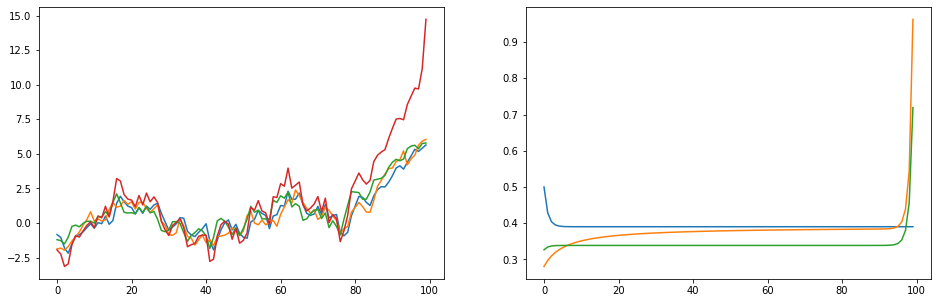

In [18]:
fig, axes = plt.subplots(1, 2)
fig.set_size_inches(16, 5)
axes[0].plot(np.arange(T), X_pred_t)
axes[0].plot(np.arange(T), X)
axes[0].plot(np.arange(T), X_pred_r_t)
axes[0].plot(np.arange(T), X_pred_s)
axes[1].plot(np.arange(T), k_pred_t)
axes[1].plot(np.arange(T), k_pred_r_t)
axes[1].plot(np.arange(T), k_pred_s)

пункт 3:

In [19]:
d0, T, a1, b1, A1, B1 = (1, 100, -0.5, 0.5, 1, 1)
m0 = 0.0

In [20]:
A1_0, B1_0, V1_0, W1_0 = (1, 1, np.random.normal(loc=m0, scale=d0), np.random.normal(loc=m0, scale=d0))
X1_0 = np.random.normal(loc=m0, scale=d0)
Y1_0 = A1_0 * X1_0 + B1_0 * W1_0

In [21]:
X1, Y1 = create_real(m0, d0, a1, b1, A1, B1, X1_0, Y1_0, T)

In [22]:
X1_pred_0, Y1_pred_0, k1_pred_0 = start_pred(A1, B1, m0, d0, Y1_0)

In [23]:
X1_pred_t, k1_pred_t = make_pred_forward(a1, b1, A1, B1, X1_pred_0, k1_pred_0)

100%|██████████| 99/99 [00:00<00:00, 83180.31it/s]


In [24]:
k1 = [d0]
for i in range(1, T):
    k1.append(a1 * k1[i - 1] * a1 + b1**2)
k1 = k1[::-1]

In [25]:
Y1_reverse = copy.copy(Y1)[::-1]

In [26]:
X1_pred_r_t, k1_pred_r_t = make_pred_reverse(a1, A1, B1, k1, Y1_reverse)

100%|██████████| 99/99 [00:00<00:00, 59506.46it/s]


In [29]:
k1_forward = k1[::-1]

k1_pred_s = [1. / ((1. / k1_pred_t[i]) + (1. / k1_pred_r_t[i]) - (1. / k1_forward[i])) for i in range(T)]
X1_pred_s = [k1_pred_s[i] * ((1. / k1_pred_t[i]) * X1_pred_t[i] + (1. / k1_pred_r_t[i]) * X1_pred_r_t[i]) for i in range(T)]

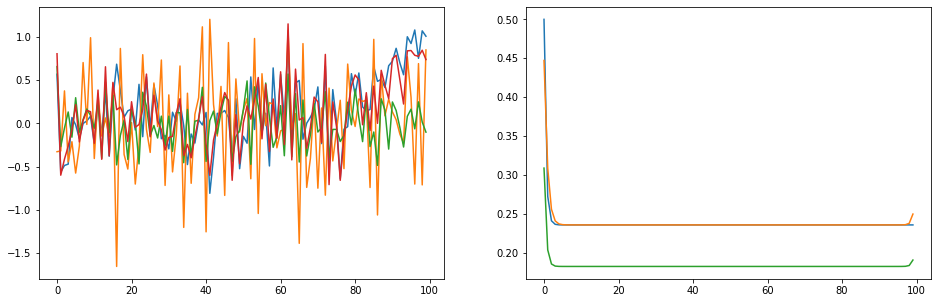

In [30]:
fig, axes = plt.subplots(1, 2)
fig.set_size_inches(16, 5)
axes[0].plot(np.arange(T), X1_pred_t)
axes[0].plot(np.arange(T), X1)
axes[0].plot(np.arange(T), X1_pred_r_t)
axes[0].plot(np.arange(T), X1_pred_s)
axes[1].plot(np.arange(T), k1_pred_t)
axes[1].plot(np.arange(T), k1_pred_r_t)
axes[1].plot(np.arange(T), k1_pred_s)